### Name: Julio Portella
### NetID: jjp58

***

In [339]:
import pandas as pd
import sqlite3
import psycopg2
import numpy as np
conn_string = "host='localhost' dbname='mimic' user='postgres' password='postgres'"
conn = psycopg2.connect(conn_string)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.linear_model import LogisticRegressionCV

# BME 590 Data Science and Health
## Final Project

For the final project, the chosen subject is finding the most relevant factors for the newborns' readmission at the NICU using MIMIC III. My main motivation for this is because I came from a family of doctors related to the newborns. As a result of my upbringing, I listened about the issues that newborns face specially when they go to the NICU. 

### Overview and Background

Compared to the patients that go to the Intesive Care Unit (ICU) where mortality rates can go up to 19% in US[1]. Neonates that goes to the Neonate Intensive Care Unit (NICU) tend to be way lower, specially in well developed countries. Given this information, re-hospitalization after initial discharge from NICU has become a studied subject around the world[2] and the most relevant issue to do research about NICUs compared to the ICU. 

Many studies related to NICUs are focus on preterm births or the length of stay. For this project, the general goal is to know which factors are more relevant for being readmitted to the NICU and see if they are similar to the ones that appear in previous studies.

The data used for this project is MIMIC III which comes from a hospital in Israel. Given that Israel is a developed nation, the expected amount of readmission should be low.

### Data

Given the size of mimic-iii, the first stept to take is to select all the newborn patients that were admited into the NICU. To do this, there are many approaches, one of them is getting all the tables separated and perform the joins using the available tools at python. Another one is to perform the inner joins and processing in a query or a stored procedure. For this project, the chosen option is to perform a query to get most of the data processed into a unique table. The technical reason for this choice is that databases tend to be faster than dataframes in joinning tables and performing some operations.

In [13]:
conn = psycopg2.connect(conn_string)
cur = conn.cursor()
cur.execute("""\
SELECT dicd.subject_id,dicd.hadm_id,dicd.seq_num,diag.icd9_code,
	diag.short_title,diag.long_title,icu_d.diagnosis,
	icu_d.icu_intime,icu_d.icu_outtime,icu_d.gender,
	icu_d.deathtime,icu_d.age,icu_d.preiculos,
	icu_d.hospital_expire_flag,icu_d.icustay_expire_flag,
	icu_d.has_readmission,icu_d.has_readmission_ext,
	icu_d.has_readmission_int,icu_d.NUMBER_INT_READMISSION
FROM mimiciii.diagnoses_icd dicd
INNER JOIN mimiciii.d_icd_diagnoses diag ON dicd.icd9_code=diag.ICD9_CODE
INNER JOIN (
SELECT DISTINCT\
    ie.subject_id,
    ie.hadm_id, 
    adm.diagnosis,
    --ie.icustay_id,
    (SELECT MIN(intime) FROM mimiciii.icustays WHERE subject_id=ie.subject_id AND hadm_id=ie.hadm_id) AS ICU_INTIME,
    (SELECT MAX(outtime) FROM mimiciii.icustays WHERE subject_id=ie.subject_id AND hadm_id=ie.hadm_id) AS ICU_OUTTIME,
    --MIN(ie.intime) AS FIRST_ICU_INTIME,
    --ie.outtime AS REAL_OUTTIME,
    pat.gender,
    adm.deathtime,
    ROUND((cast((SELECT MIN(intime) FROM mimiciii.icustays WHERE subject_id=ie.subject_id AND hadm_id=ie.hadm_id) as date) - cast(pat.dob as date))/365.242, 2) AS age,
    ROUND((cast((SELECT MIN(intime) FROM mimiciii.icustays WHERE subject_id=ie.subject_id AND hadm_id=ie.hadm_id) as date) - cast(adm.admittime as date))/365.242, 2) AS preiculos,
    CASE
        WHEN adm.hospital_expire_flag = 1 then TRUE
    ELSE FALSE
    END AS hospital_expire_flag,
    CASE
        WHEN adm.deathtime BETWEEN ie.intime and ie.outtime
            THEN TRUE
        WHEN adm.deathtime <= ie.intime
            THEN TRUE
        WHEN adm.dischtime <= ie.outtime
            AND adm.discharge_location = 'DEAD/EXPIRED'
            THEN TRUE
        ELSE FALSE
        END AS ICUSTAY_EXPIRE_FLAG,
     CASE
	WHEN (select count(1) from mimiciii.admissions where subject_id=ie.subject_id)>1
	THEN TRUE
	WHEN (select count(1) from mimiciii.icustays where subject_id=ie.subject_id)>1
	THEN TRUE
	ELSE FALSE
	END AS HAS_READMISSION,
     CASE
	WHEN (select count(1) from mimiciii.admissions where subject_id=ie.subject_id)>1
	THEN TRUE
	ELSE FALSE
	END AS HAS_READMISSION_EXT,
     CASE
	WHEN (select count(1) from mimiciii.icustays where hadm_id=ie.hadm_id and subject_id=ie.subject_id)>1
	THEN TRUE
	ELSE FALSE
	END AS HAS_READMISSION_INT,
      CASE
	WHEN (select count(1) from mimiciii.icustays where hadm_id=ie.hadm_id and subject_id=ie.subject_id)>1
	THEN (select count(1) from mimiciii.icustays where hadm_id=ie.hadm_id and subject_id=ie.subject_id)
	ELSE 0
	END AS NUMBER_INT_READMISSION
FROM mimiciii.icustays ie
INNER JOIN mimiciii.patients pat
ON ie.subject_id = pat.subject_id
INNER JOIN mimiciii.admissions adm
ON ie.hadm_id = adm.hadm_id
WHERE ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) <= 1
) icu_d ON icu_d.SUBJECT_ID=dicd.subject_id and icu_d.hadm_id=dicd.hadm_id
""")

tmp = cur.fetchall()

# Extract the column names
col_names = []
for elt in cur.description:
    col_names.append(elt[0])
    pass
# Create the dataframe, passing in the list of col_names extracted from the description
df = pd.DataFrame(tmp, columns=col_names)
conn.close ()

After performing the query, we can see the results from the databse

In [15]:
df.head()

,subject_id,hadm_id,seq_num,icd9_code,short_title,long_title,diagnosis,icu_intime,icu_outtime,gender,deathtime,age,preiculos,hospital_expire_flag,icustay_expire_flag,has_readmission,has_readmission_ext,has_readmission_int,number_int_readmission
0,2,163353,1,V3001,Single lb in-hosp w cs,"Single liveborn, born in hospital, delivered b...",NEWBORN,2138-07-17 21:20:07,2138-07-17 23:32:21,M,NaT,0.00,0.00,False,False,False,False,False,0
1,2,163353,2,V053,Need prphyl vc vrl hepat,Need for prophylactic vaccination and inoculat...,NEWBORN,2138-07-17 21:20:07,2138-07-17 23:32:21,M,NaT,0.00,0.00,False,False,False,False,False,0
2,2,163353,3,V290,NB obsrv suspct infect,Observation for suspected infectious condition,NEWBORN,2138-07-17 21:20:07,2138-07-17 23:32:21,M,NaT,0.00,0.00,False,False,False,False,False,0
3,5,178980,1,V3000,Single lb in-hosp w/o cs,"Single liveborn, born in hospital, delivered w...",NEWBORN,2103-02-02 06:04:24,2103-02-02 08:06:00,M,NaT,0.00,0.00,False,False,False,False,False,0
4,5,178980,2,V053,Need prphyl vc vrl hepat,Need for prophylactic vaccination and inoculat...,NEWBORN,2103-02-02 06:04:24,2103-02-02 08:06:00,M,NaT,0.00,0.00,False,False,False,False,False,0


This table contains information about all the hospitalizations that have a NICU visit. Some patients may be admited into the hospital and in thier stay they went to the NICU multiple times, thus all the derivations to the NICU are counted as one for that hospital stay. The description of the most relevant columns:
 - 
patient_id: The Id of the patient 
 - hadm_id: The Id of the hospital admission
 - icd9_code: The icd9 code for the patient
 - short_title: A short description of the icd9 code
 - long_title: A long description for the icd9 code
 - diagnosis: A diagnostic written by the personal at the time of admission, not relevant for further analysis
 - icu_intime: Admission time at the NICU
 - icu_outtime: Time when the patient is out of the NICU
 - gender: Patient's gender
 - deathtime: Time when the patient died
 - has_readmission: Flag that indicates if the patient has a readmission, this if a patient was readmitted more than once when it was at the hospital


### Exploratory Data Analysis

In general lines, our data is composed by 7870 unique newborns who were admited into the NICU. The amount is quite similar, having a slightly higher percentage of males

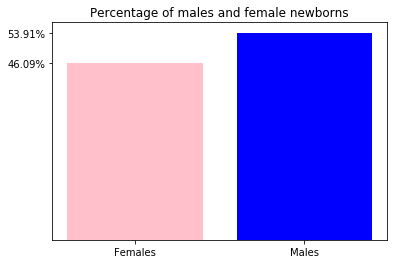

In [92]:
from matplotlib.ticker import FuncFormatter
percentage_fem=df[['subject_id','gender']].drop_duplicates().groupby('gender').count().values[0,0]/df.subject_id.nunique()*100
percentage_male=df[['subject_id','gender']].drop_duplicates().groupby('gender').count().values[1,0]/df.subject_id.nunique()*100
top=[('Females',percentage_fem),('Males',percentage_male)]

formatter = FuncFormatter(lambda y, pos: "%.2f%%" % (y))
labels, ys = zip(*top)
xs = np.arange(len(labels)) 
#width = 1
colors = ['pink','blue']
plt.bar(xs, ys,  align='center',color=colors)
plt.gca().yaxis.set_major_formatter(formatter)
plt.xticks(xs, labels) #Replace default x-ticks with xs, then replace xs with labels
plt.yticks(ys)
plt.title('Percentage of males and female newborns')
plt.show()

The total number of unique diagnostics in this dataset is 872 from the 44413 records in the dataset, many patients may present multiple diagnostic codes for a single hospitalization.
From the existing unique diagnostic codes in the dataset, let's see which ones are the most popular

In [114]:
df[['short_title','subject_id','hadm_id']].groupby(['short_title'])['subject_id'].count().nlargest(20)

short_title
Need prphyl vc vrl hepat    5694
NB obsrv suspct infect      5514
Single lb in-hosp w/o cs    3491
Single lb in-hosp w cs      2747
Neonat jaund preterm del    2255
Routine circumcision        1991
Respiratory distress syn    1313
Primary apnea of newborn    1043
Twin-mate lb-in hos w cs     999
Preterm NEC 2000-2499g       918
33-34 comp wks gestation     881
35-36 comp wks gestation     859
NB transitory tachypnea      754
Preterm NEC 2500+g           735
Fetal/neonatal jaund NOS     629
Neonatal bradycardia         606
Resp prob after brth NEC     582
31-32 comp wks gestation     487
Preterm NEC 1750-1999g       474
Perinatal condition NEC      458
Name: subject_id, dtype: int64

We can see that some of the popular diagnostics are descriptions about the patient, injections for prophylactic vaccines, and circumcision, a typical procedure, given that the data came from a hospital in Israel. However, other critical diagnosis can be found such as primary apnea or neonatal bradycardia

In [127]:
df['LENGTH_STAY']=(df['icu_outtime']-df['icu_intime']).dt.days

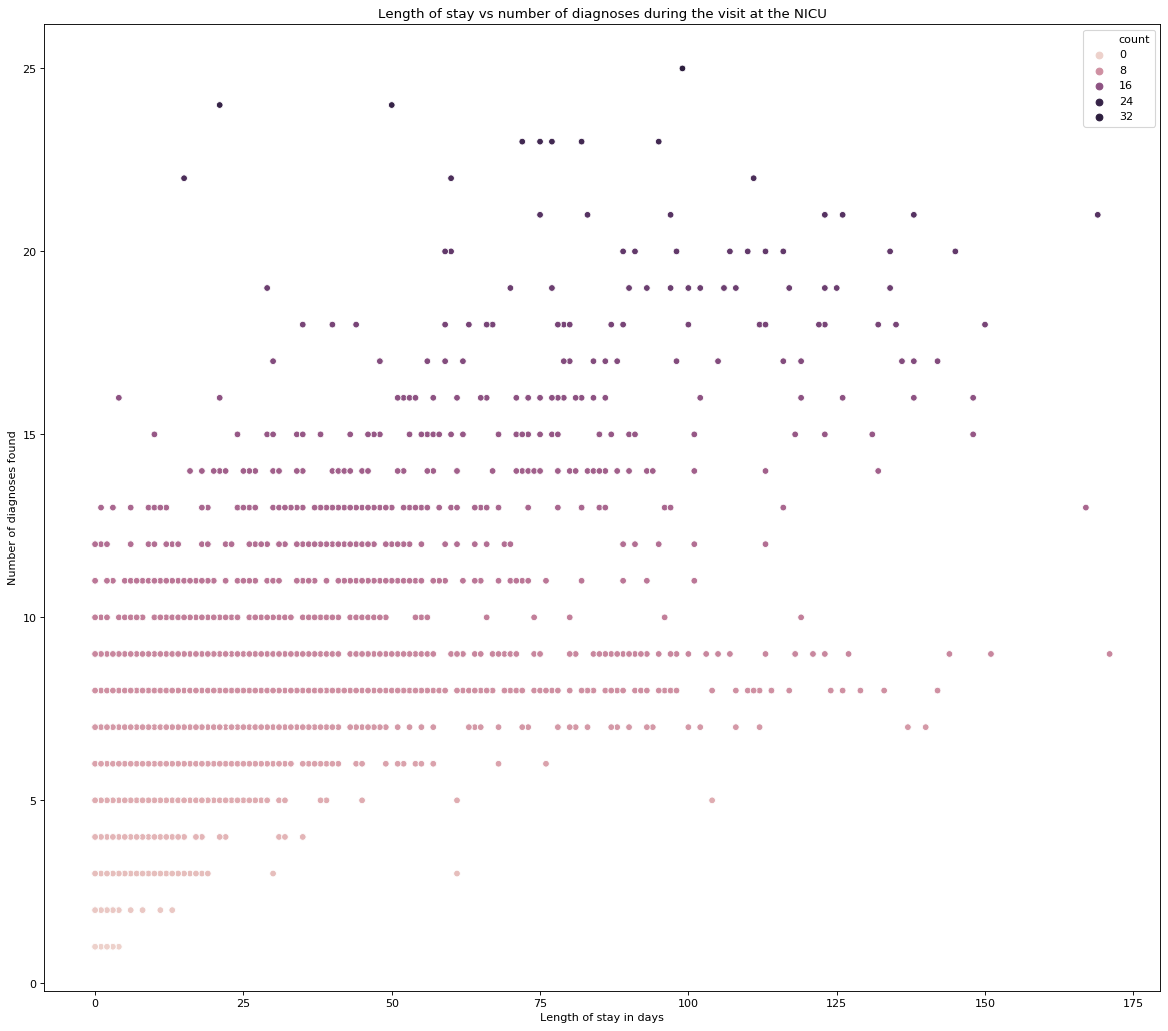

In [130]:
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
counted=df.groupby(['subject_id','LENGTH_STAY']).icd9_code.agg('count').to_frame('count').reset_index()
ax = sns.scatterplot(x="LENGTH_STAY", y="count", hue="count",data=counted)
plt.title('Length of stay vs number of diagnoses during the visit at the NICU')
plt.ylabel('Number of diagnoses found')
plt.xlabel('Length of stay in days')
plt.show()

In this case, it looks like the more time the newborn spends at the NICU, the greater number of diagnoses are found up to a point

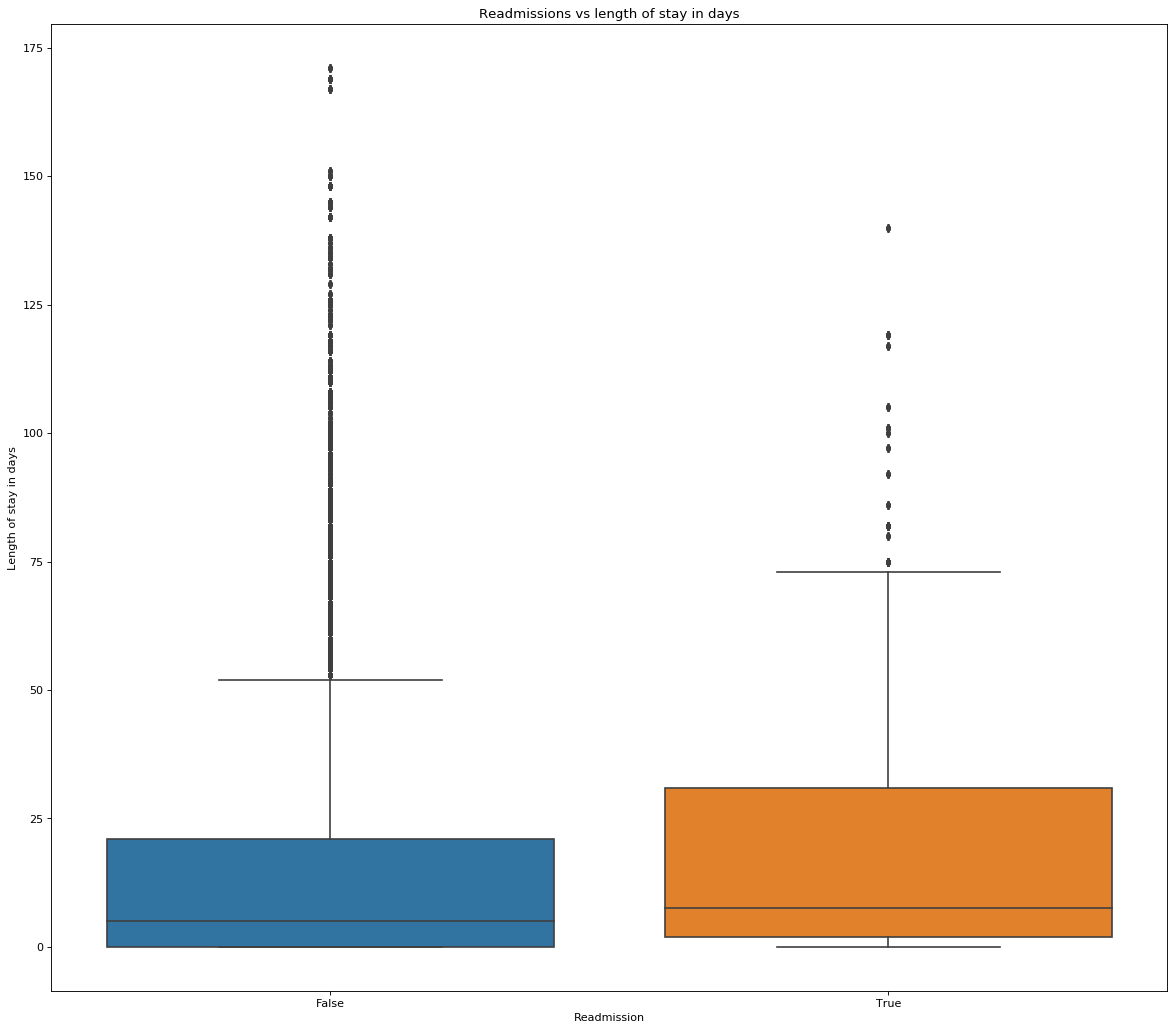

In [480]:
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax = sns.boxplot(x="has_readmission", y="LENGTH_STAY", data=df)
plt.title('Readmissions vs length of stay in days')
plt.ylabel('Length of stay in days')
plt.xlabel('Readmission')
plt.show()

The goal for the study is to find the main causes for readmission at the NICU, for this plot, we can see that newborns that were readmited into the NICU have a higher mean in their length stay in days. Note that they are still a minority compared to the rest of the cases but they are more than the number of deaths. 

In [157]:
df[['subject_id','has_readmission']].drop_duplicates().groupby('has_readmission').count()

,subject_id
has_readmission,
False,7535
True,335


As an extra insight for the EDA, it looks like the number of patients that have died tend to stay less at the NICU, this means that their diagnosis is too critical that they may die on the first visit. For this study, the amount of total patients that died is 64 or about a 0.14% of the total amount of cases that goes to the NICU.

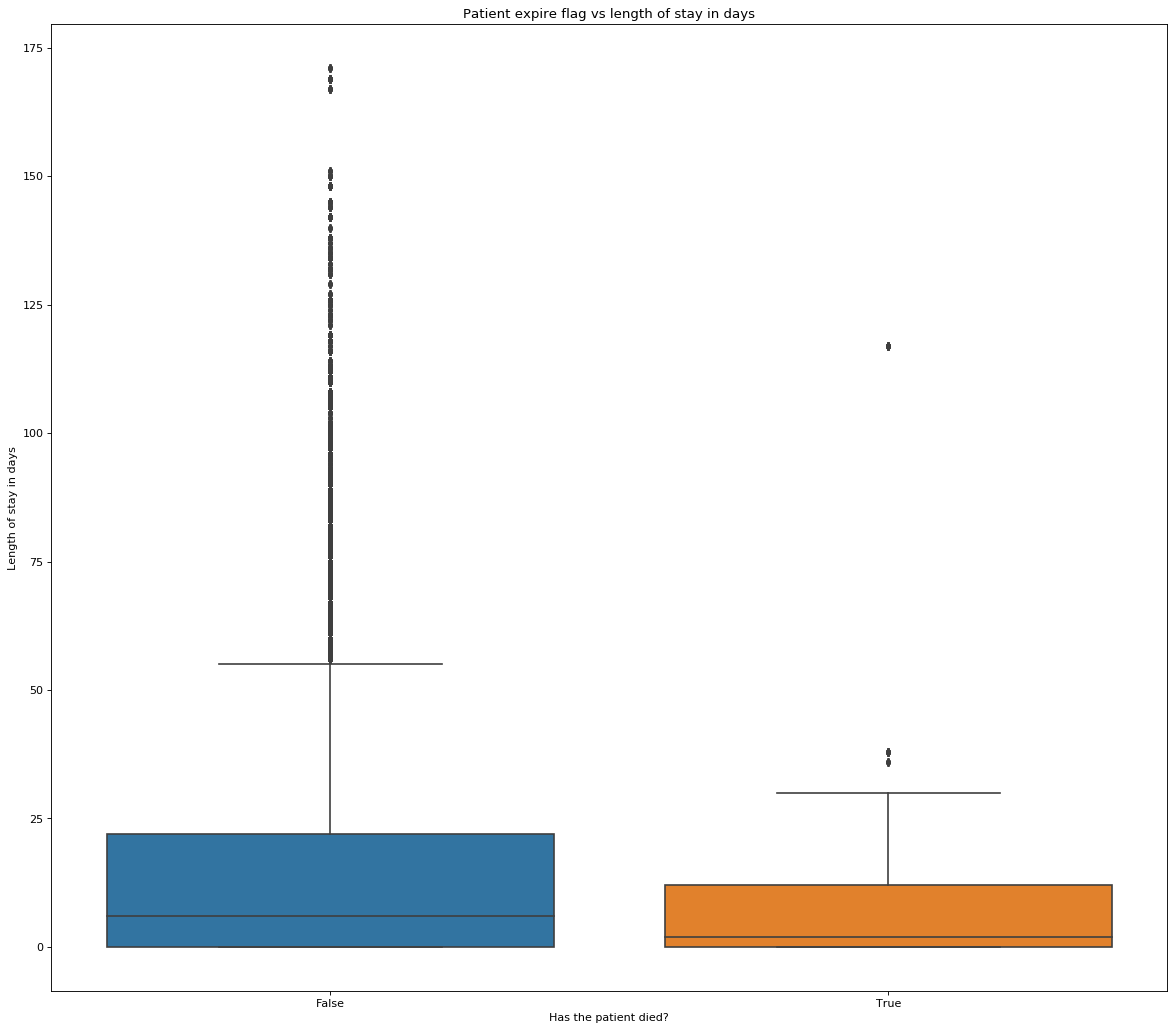

In [138]:
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax = sns.boxplot(x="hospital_expire_flag", y="LENGTH_STAY", data=df)
plt.title('Patient expire flag vs length of stay in days')
plt.ylabel('Length of stay in days')
plt.xlabel('Has the patient died?')
plt.show()

### Modeling

The data seems to be inbalanced, cases where newborns are readmitted into the NICU are only 4.45% of the total cases. Thus balancing techniques needs to be considered. Also, precision recall curves are going to be more relvant than the convensional ROC curve. Finally, interpretability is critical here because we want to know which diagnoses are more critical for the newborn readmission.

In [481]:
df_model=df.copy()

In [483]:
diagn_chco=df_model.groupby(['subject_id','hadm_id', 'short_title']).size().unstack()
diagn_chco.head()

,short_title,24 comp weeks gestation,25-26 comp wks gestation,27-28 comp wks gestation,29-30 comp wks gestation,31-32 comp wks gestation,33-34 comp wks gestation,35-36 comp wks gestation,37+ comp wks gestation,<24 comp wks gestation,Ab ftl hrt rt/rh b/f lab,...,Viral infection NOS,Viral meningitis NEC,Viral meningitis NOS,Vitamin D deficiency NOS,Vocal cord disease NEC,Vocal paral unilat part,Vocal paral unilat total,Vomiting alone,Von willebrand's disease,Vscurt rflx npht uniltrl
subject_id,hadm_id,,,,,,,,,,,,,,,,,,,,,
2,163353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,178980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,118037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,159514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,184167,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [484]:
diagn_chco=diagn_chco.fillna(0)
for i in diagn_chco.columns.difference(['SUBJECT_ID','HADM_ID']):
    diagn_chco[i]=(diagn_chco[i] > 0).astype(int)
    pass
diagn_chco.head()

,short_title,24 comp weeks gestation,25-26 comp wks gestation,27-28 comp wks gestation,29-30 comp wks gestation,31-32 comp wks gestation,33-34 comp wks gestation,35-36 comp wks gestation,37+ comp wks gestation,<24 comp wks gestation,Ab ftl hrt rt/rh b/f lab,...,Viral infection NOS,Viral meningitis NEC,Viral meningitis NOS,Vitamin D deficiency NOS,Vocal cord disease NEC,Vocal paral unilat part,Vocal paral unilat total,Vomiting alone,Von willebrand's disease,Vscurt rflx npht uniltrl
subject_id,hadm_id,,,,,,,,,,,,,,,,,,,,,
2,163353,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,178980,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,118037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,159514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,184167,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [485]:
fn_df=pd.merge(diagn_chco,df_model[['subject_id','hadm_id','has_readmission','LENGTH_STAY']].drop_duplicates(),how='inner',  left_on=['subject_id','hadm_id'], right_on=['subject_id','hadm_id'])
fn_df.head()

,subject_id,hadm_id,24 comp weeks gestation,25-26 comp wks gestation,27-28 comp wks gestation,29-30 comp wks gestation,31-32 comp wks gestation,33-34 comp wks gestation,35-36 comp wks gestation,37+ comp wks gestation,...,Viral meningitis NOS,Vitamin D deficiency NOS,Vocal cord disease NEC,Vocal paral unilat part,Vocal paral unilat total,Vomiting alone,Von willebrand's disease,Vscurt rflx npht uniltrl,has_readmission,LENGTH_STAY
0,2,163353,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,False,0.0
1,5,178980,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,False,0.0
2,7,118037,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,True,2.0
3,8,159514,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,False,1.0
4,10,184167,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,False,8.0


Given that patients that were readmited at the NICU are a minority, balancing techniques have to be applied. In this case, the majority is going to be undersampled in order to balance the dataset.

In [486]:
all_positives=fn_df.loc[fn_df.has_readmission==True].copy()
some_negatives=fn_df.loc[fn_df.has_readmission==False].sample(n = all_positives.shape[0]*2).copy()
balanced_dataset=all_positives.append(some_negatives, ignore_index=True)

In [487]:
X_train, X_test, y_train, y_test = train_test_split(balanced_dataset.drop(['subject_id', 'hadm_id','has_readmission'], axis=1), balanced_dataset['has_readmission'], test_size = 0.2)

In [495]:
clf = LogisticRegressionCV(cv=5, random_state=0,solver='liblinear').fit(X_train,y_train)

Let's see the model's AUC

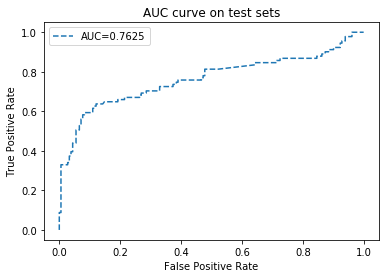

In [496]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

y_true = y_test.values.ravel()
y_probas = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_probas)
ns_auc = roc_auc_score(y_true, y_probas)
plt.plot(fpr, tpr, marker='', linestyle='dashed',label="AUC={:.4f}".format(ns_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('AUC curve on test sets')
plt.show()

As allways, in these problems, usually the AUC is not as reliable as the precission recall curve

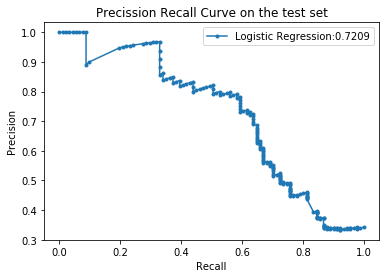

In [498]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
#y_pred = logreg.predict_proba(X_test)
y_pred = clf.predict_proba(X_test)[:, 1]
y_pred_abs = clf.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
f1 = f1_score(y_test, y_pred_abs)
auc_c = auc(recall, precision)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot(recall, precision, marker='.', label="Logistic Regression:{:.4f}".format(auc_c))

plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.title('Precission Recall Curve on the test set')
plt.show()

In this plot, we can see that the precission recall looks good, which can tell us that the features are relevant. Let's see the coefficients and which ones are relevant for newborn readmission into the NICU

FInally, let's see the value group all the predictors and sort them. In this dataframe, we can see that the the predictors with possitives values increases the chances of being readmitted to the NICU. One example is "Fetal/neonatal jaund NOS" which has a coefficient of 1.45 and if asked to a pediatrician, they say that this is actually an actual cause of readmission at the NICU.

In [509]:
coefs = pd.DataFrame(list(zip(X_train.columns, clf.coef_[0])), 
               columns =['Predictor', 'Value'])
coefs.sort_values('Value', ascending=False)

,Predictor,Value
94,Atresia large intestine,2.392333
315,Exceptionally large baby,1.938190
831,Unilat ing hernia w obst,1.896597
490,Mat cocaine aff NB/fet,1.876936
651,Perinatal intest perfor,1.779372
...,...,...
817,Twin-mate lb-in hos w cs,-2.289152
750,Single lb in-hosp w/o cs,-2.599238
816,Twin-mate lb-hosp w/o cs,-2.660414
749,Single lb in-hosp w cs,-2.739487


In [507]:
coefs.loc[coefs.Predictor=='Fetal/neonatal jaund NOS']

,Predictor,Value
357,Fetal/neonatal jaund NOS,1.448301


Another way to make sure that the factors are accurate is using another model and compare. In this case the model to use is random forest classifier. The reason to combine both results is to see which coefficients are relevant. Let's see the AUC and the Precission-Recall Curve area

In [505]:
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier() 
rf.fit(X_train, y_train) 
rf.score(X_test, y_test)
predictions = rf.predict_proba(X_test)[:, 1]
print('AUC: {}'.format(roc_auc_score(y_test, predictions)))
print('Average Precision (Area under Precision-Recall Curve): {}'.format(average_precision_score(y_test, predictions)))

AUC: 0.8372479169182465
Average Precision (Area under Precision-Recall Curve): 0.76887094683999


Like in the previous process, let's create a table where we can have the importance and the predictors together. In this case, we don't know which predictors have a possitive influnce in the readmission to the NICU. Given this information, it is time to combine both tables

In [503]:
import pandas as pd
feature_importances = pd.DataFrame(list(zip(X_train.columns, rf.feature_importances_)), 
               columns =['Predictor', 'Importance']).sort_values('Importance',ascending=False)
feature_importances

,Predictor,Importance
871,LENGTH_STAY,0.122707
546,NB obsrv suspct infect,0.058477
357,Fetal/neonatal jaund NOS,0.058426
562,Need prphyl vc vrl hepat,0.057206
750,Single lb in-hosp w/o cs,0.037874
...,...,...
47,Acne NEC,0.000000
537,NB integument cond NOS,0.000000
269,Disaccharidase def/malab,0.000000
535,NB hypoxia,0.000000


We can see that the legth of stay is a critical factor in the readmission of the patient.

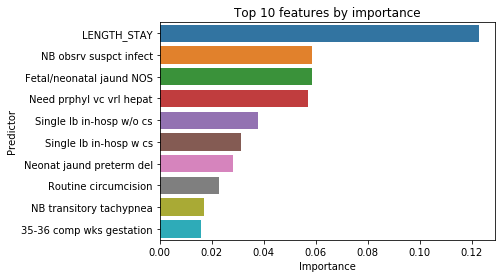

In [504]:
sns.barplot(x="Importance", y="Predictor", data=feature_importances.sort_values('Importance',ascending=False).nlargest(10,'Importance'))
plt.xlabel('Importance')
plt.ylabel('Predictor')
plt.title('Top 10 features by importance')
plt.show()

Let's merge both datasets into one that combines the importance and the value of the predictor

In [461]:
coefs_df=pd.merge(coefs,feature_importances,how='inner',  left_on=['Predictor'], right_on=['Predictor'])
coefs_df.head()

,Predictor,Value,Importance
0,24 comp weeks gestation,1.786679,0.002357
1,25-26 comp wks gestation,0.334824,0.005495
2,27-28 comp wks gestation,-0.396608,0.003988
3,29-30 comp wks gestation,1.019509,0.007119
4,31-32 comp wks gestation,-0.236485,0.010385


Let's see only the predictors that increase the chances of readmitting a newborn

In [478]:
coefs_df.loc[coefs_df.Value>0].sort_values(['Importance'],ascending=False)

,Predictor,Value,Importance
136,Fetal/neonatal jaund NOS,0.823452,0.057223
287,Preterm NEC 2500+g,0.035016,0.019607
57,Cardiac murmurs NEC,1.456408,0.018714
6,35-36 comp wks gestation,0.936751,0.018541
267,Perinatal condition NEC,0.898790,0.018463
...,...,...,...
10,Abdmnal mass rt lwr quad,0.216727,0.000067
113,Elev transaminase/ldh,0.024904,0.000044
258,Oth spcf hypoglycemia,0.024904,0.000036
103,Disease of larynx NEC,0.024904,0.000016


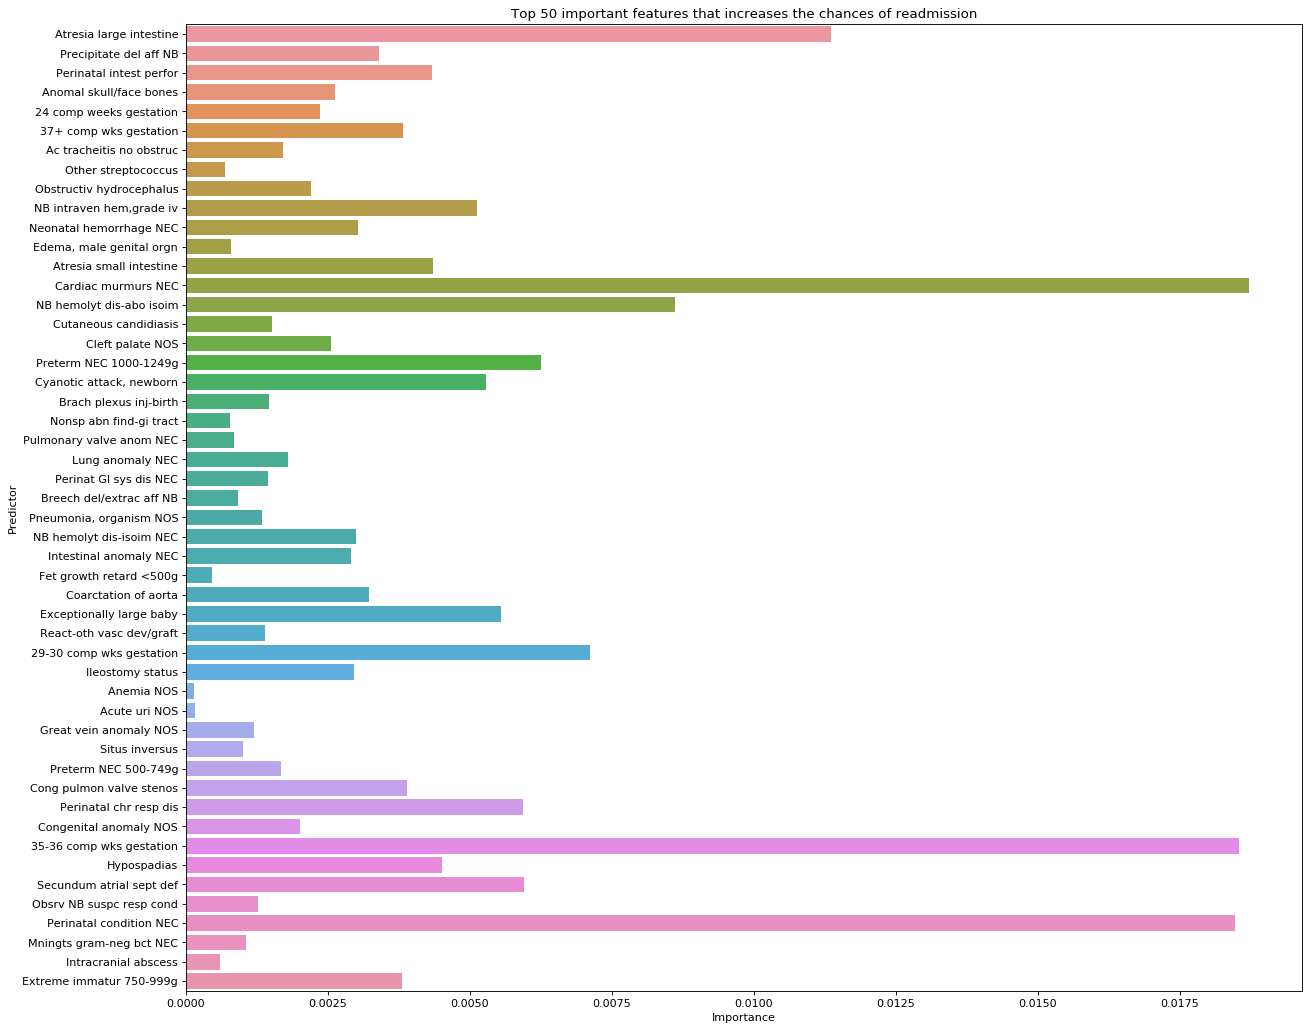

In [526]:
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.barplot(x="Importance", y="Predictor", data=coefs_df.loc[coefs_df.Value>0].sort_values('Importance',ascending=False).nlargest(50,'Value'))
plt.xlabel('Importance')
plt.ylabel('Predictor')
plt.title('Top 50 features that increases the chances of readmission')
plt.show()

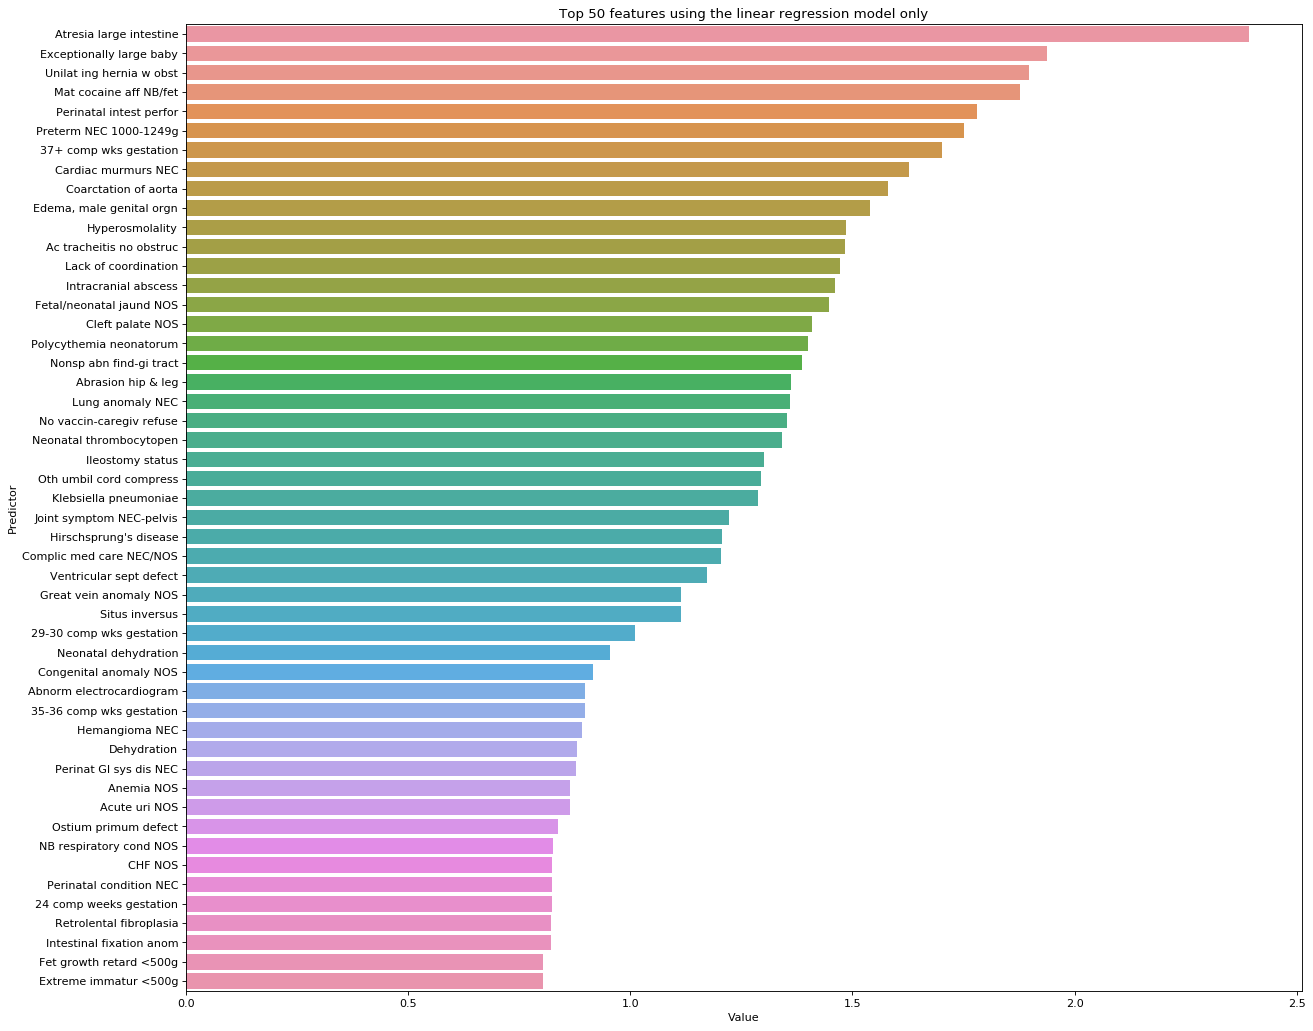

In [528]:
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.barplot(x="Value", y="Predictor", data=coefs.loc[coefs.Value>0].sort_values('Value',ascending=False).nlargest(50,'Value'))
plt.xlabel('Value')
plt.ylabel('Predictor')
plt.title('Top 50 features using the linear regression model only')
plt.show()

### Suggestions & Conclusions

The purpose of this model is not to be accurate but to be used as a way to know which diagnostics are correlated with the probability of having a readmission at the NICU. Many of these predictors appear in medical literature and can be mentioned by seasoned pediatricians.

My main difficulty for this project is the amount of diatnostics that I have to use, up to 871. A good way to remove all these features is to use more general categories, such as classifying all breath issues into smaller categories. This at the same time gave me issues to find the p-values for the coefficients. That's why I decided to use random forest, as a way to find which factors are useful instead of noise. That's why some factors are missing at the top 50 in the last two graphs.

A suggestion for this study is applying feature engineering in order to reduce the amount of features to use and use bigger groups for some icd9 diagnostics, many of them are quite redundant. Also, it will be interesting to use data from other NICUs, so the model can be tested more. It is important to apply a more rigorous hypotesis testing, such as p-values or alternatives in order to have better results. As mentioned before, I've tried many times to find the p-values to the coefficients only to find issues related to the amount of features used.

### Bibliography

1.	Icu Outcomes
https://healthpolicy.ucsf.edu/icu-outcomes-Icu 
2.	Doctor, T., Harnaen, E., Seith, B., Tan, K. & Craig, S. (2017) "Risk Factors for Hospital Readmission and Follow Up after NICU Discharge of Infants born at Extremely LOw Gestational Age in Metropolitan Melbourne" (https://clinmedjournals.org/articles/ijpr/international-journal-of-pediatric-research-ijpr-3-028.pdf)
3.	Harrison, K., Gilbert, R., Cromwell, D., Oddie, Sam., Van der Meulen, J.(2017) "Newborn Length of Stay and RIsk of Readmission" (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5518288/pdf/PPE-31-221.pdf)
4.	Pezzati, M. (2014) Hospital readmissions in late preterm infants